In [ ]:
path = 'Potholes/annotated-images/'
splits = 'Potholes/splits.json'

In [ ]:
import torch
import json
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET
from torch.utils.data import DataLoader
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.io import decode_image
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split

def read_xml(path: str) -> list:  

    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)
    
    return obj_list

def collate_fn(batch):
    return tuple(zip(*batch))

def visualize_boxes(images, annotations):
    all_images = []
    all_overlay = []

    for image, annotation in zip(images, annotations):
        
        overlay = draw_bounding_boxes(image, annotation, width=2)
        all_images.append(image)
        all_overlay.append(overlay)
    
    fig, axes = plt.subplots(len(all_images), 2, figsize=(10, len(all_images) * 5))
    
    for idx, image in enumerate(all_images):
        axes[idx, 0].imshow(image.permute(1,2,0))
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(all_overlay[idx].permute(1,2,0))
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()
        

class Pothole_Dataloader(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, size=256, val=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.size = size
        self.val = val
        self.transforms = v2.Compose([
                            v2.Resize((self.size, self.size)),
                            v2.RandomHorizontalFlip()
                          ])
        self.val_transforms = v2.Compose([
                            v2.Resize((self.size, self.size))
                          ])

    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, idx):
        image = decode_image(self.image_paths[idx])
        boxes = tv_tensors.BoundingBoxes(read_xml(self.mask_paths[idx]), 
                                         format="XYXY", canvas_size=image.shape[-2:])
        if self.val:
            image, boxes = self.val_transforms(image, boxes)
        else:
            image, boxes = self.transforms(image, boxes)

        return image, boxes
    
train_mask_list = [path + f for f in json.load(open(splits))['train']]
val_mask_list = [path + f for f in json.load(open(splits))['test']]
train_img_list = [filename.replace('xml', 'jpg') for filename in train_mask_list]
val_img_list = [filename.replace('xml', 'jpg') for filename in val_mask_list]

NameError: name 'splits' is not defined

In [159]:
size = 512
batch_size = 6
num_workers = 1

In [161]:
val_img_list, test_img_list, val_mask_list, test_mask_list = train_test_split(val_img_list, val_mask_list, train_size=.5)

trainset = Pothole_Dataloader(train_img_list, train_mask_list, size=size)
valset = Pothole_Dataloader(val_img_list, val_mask_list, size=size, val=True)
testset = Pothole_Dataloader(test_img_list, test_mask_list, size=size, val=True)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader= DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [162]:
images, boxes = next(iter(train_loader))

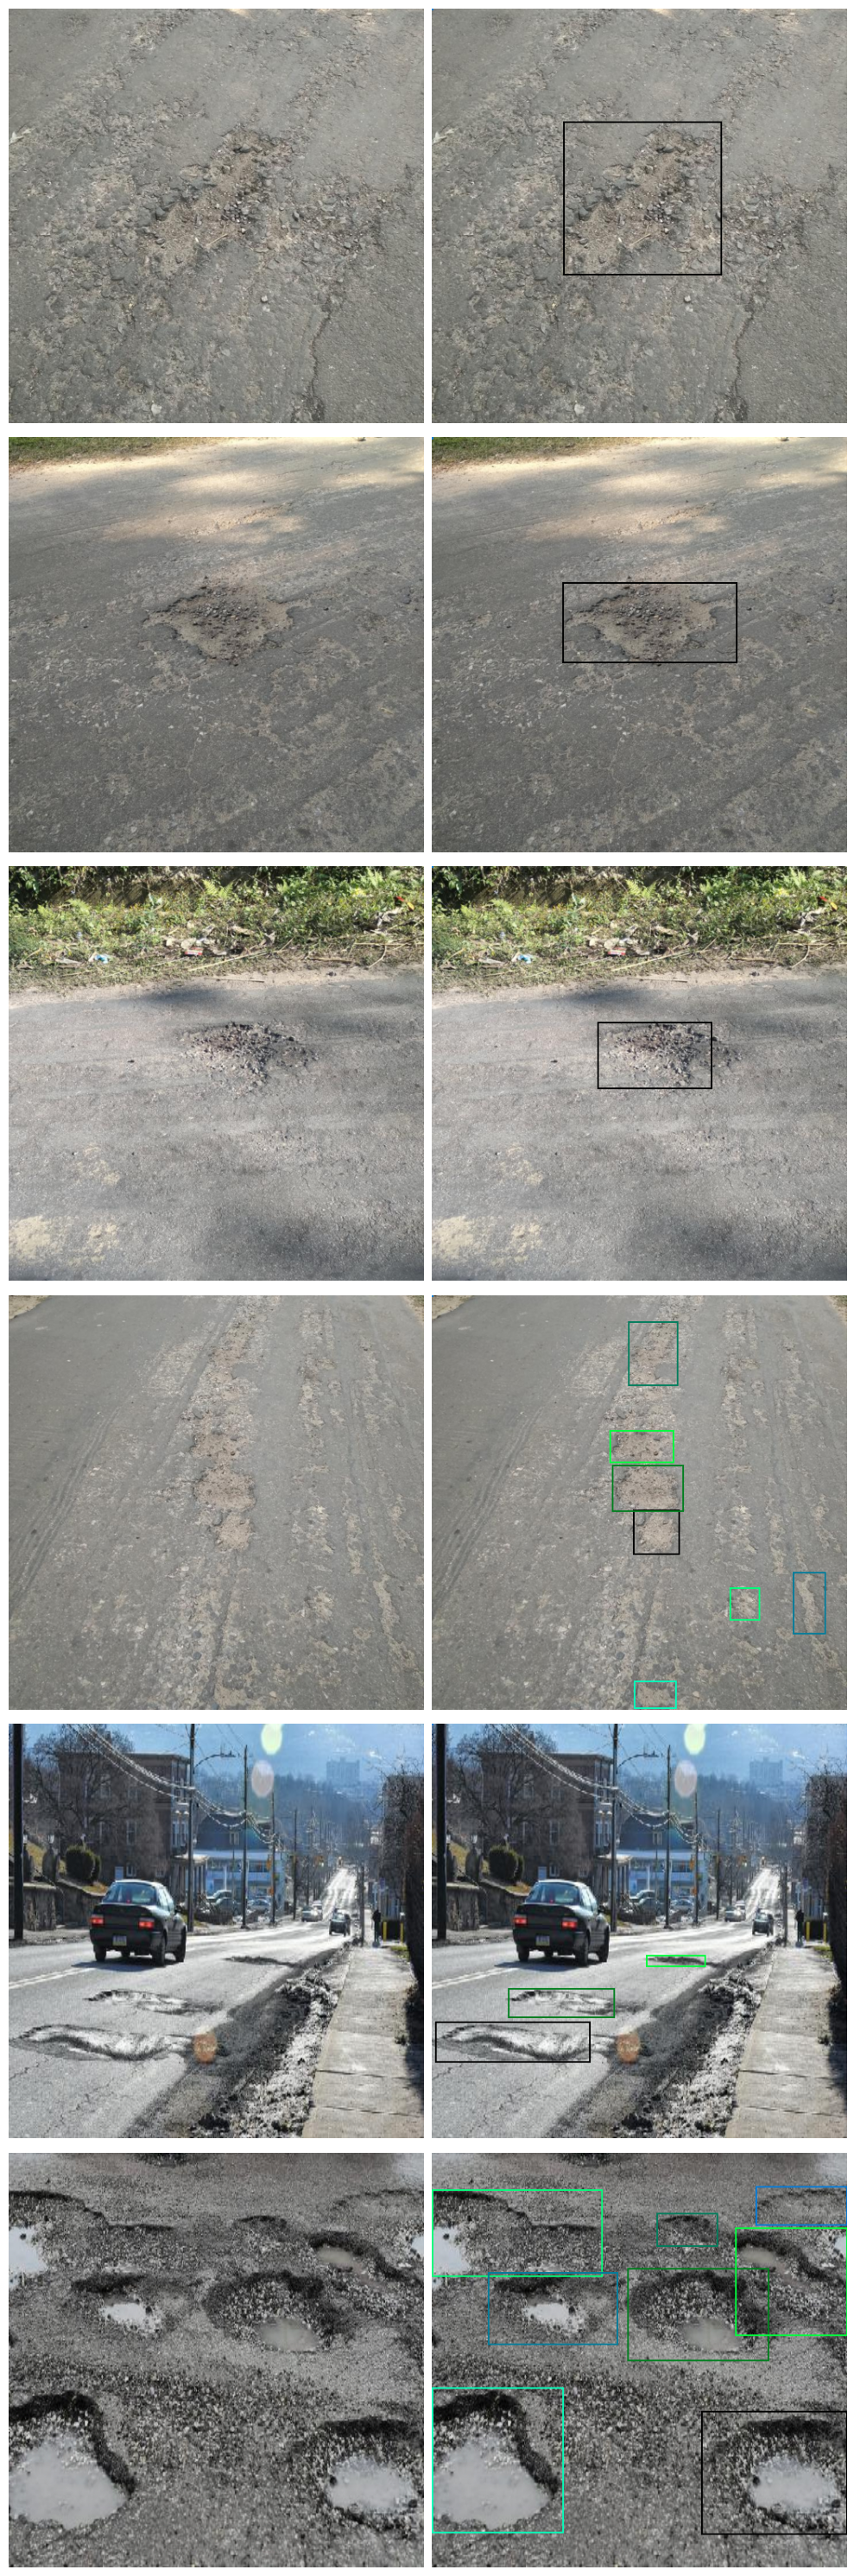

In [167]:
visualize_boxes(images, boxes)